 **Dawnload Packages**

In [1]:
!pip install --upgrade yfinance
!pip install --upgrade websockets


**Import Tesla Stock Data**

In [65]:
import yfinance as yf

# Create ticker object for Tesla Stock
ticker = yf.Ticker("TSLA")

# Get historical daily data for the last 720 days by 1 hour interval
data = ticker.history(period="720d", interval="1h")

# Print the first few rows

df = pd.DataFrame(data)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-08-02 09:30:00-04:00,292.666656,302.100006,292.666656,301.666656,9278858,0.0,0.0
2022-08-02 10:30:00-04:00,301.656647,306.666656,300.016663,304.126678,5899906,0.0,0.0
2022-08-02 11:30:00-04:00,304.199982,307.199982,301.936676,306.193329,3927116,0.0,0.0
2022-08-02 12:30:00-04:00,306.183319,307.833344,303.061981,303.829987,2830473,0.0,0.0
2022-08-02 13:30:00-04:00,303.733337,305.053314,299.508331,304.713348,4221954,0.0,0.0


**Import Libraries**

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0923 - mae: 0.1966Epoch 1 - R² Score: 0.8252
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0918 - mae: 0.1961 - val_loss: 0.1611 - val_mae: 0.2945
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0135 - mae: 0.0857Epoch 2 - R² Score: 0.9524
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0135 - mae: 0.0856 - val_loss: 0.0439 - val_mae: 0.1517
Epoch 3/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0123 - mae: 0.0819Epoch 3 - R² Score: 0.9415
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0122 - mae: 0.0819 - val_loss: 0.0539 - val_mae: 0.1693
Epoch 4/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0099 - mae: 0.0742Epoch 4 - R² Score: 0.9564
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0099 - mae: 0.0742 - val_loss: 0.0402 - val_mae: 0.1472
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0092 - mae: 0.0716Epoch 5 - R² Score: 0.9437
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37m

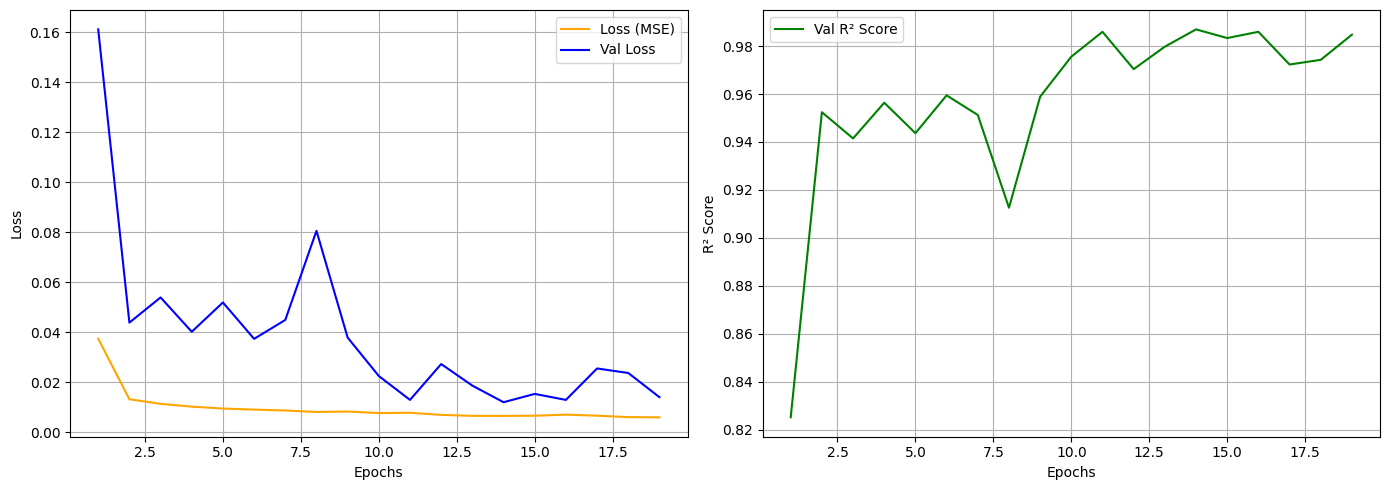

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


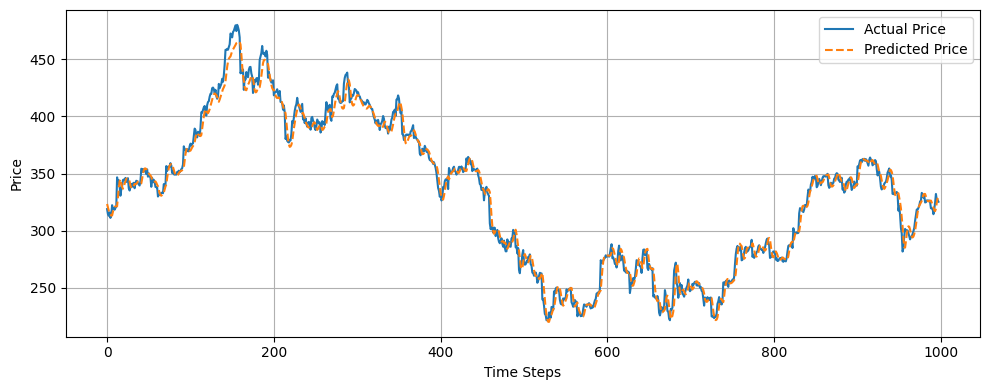

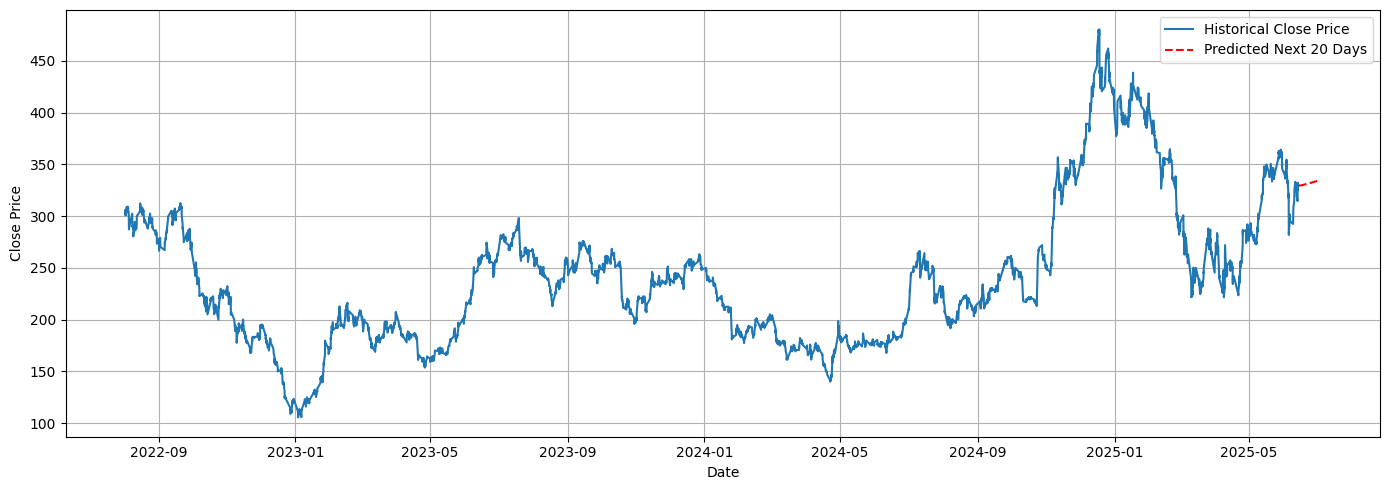

In [67]:

df.reset_index(inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

close_data = df[['Close']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data)

def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_sequences(scaled_data, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

class R2Callback(Callback):
    def __init__(self, X_val, y_val, scaler):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.scaler = scaler
        self.r2_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_inv = self.scaler.inverse_transform(y_pred)
        y_true_inv = self.scaler.inverse_transform(self.y_val.reshape(-1, 1))
        r2 = r2_score(y_true_inv, y_pred_inv)
        self.r2_scores.append(r2)
        print(f"Epoch {epoch+1} - R² Score: {r2:.4f}")

r2_callback = R2Callback(X_val, y_val, scaler)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, r2_callback],
    verbose=1
)

epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Loss (MSE)', color='orange')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, r2_callback.r2_scores, label='Val R² Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_pred_val = model.predict(X_val)
y_pred_inv = scaler.inverse_transform(y_pred_val)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(10, 4))
plt.plot(y_val_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price', linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

future_preds = []
last_seq = scaled_data[-time_step:].reshape(1, time_step, 1)
for _ in range(20):
    next_pred = model.predict(last_seq, verbose=0)
    future_preds.append(next_pred[0][0])
    last_seq = np.append(last_seq[:, 1:, :], [[[next_pred[0][0]]]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=20)

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label='Historical Close Price')
plt.plot(future_dates, future_preds_inv, label='Predicted Next 20 Days', linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Performance Prediction on basis of Metrices**

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on training data
predicted_train_scaled = model.predict(X)
predicted_train = scaler.inverse_transform(predicted_train_scaled)
actual_train = scaler.inverse_transform(y.reshape(-1, 1))

# Performance Metrics
mae = mean_absolute_error(actual_train, predicted_train)
mse = mean_squared_error(actual_train, predicted_train)
rmse = np.sqrt(mse)
r2 = r2_score(actual_train, predicted_train)

# MAPE Calculation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

mape = mean_absolute_percentage_error(actual_train, predicted_train)

# Print Metrics
print("\n Model Performance on Training Data:")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape:.2f}%")


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 Model Performance on Training Data:
MAE   : 3.2884
MSE   : 25.8340
RMSE  : 5.0827
R²    : 0.9942
MAPE  : 1.34%
